# Problem formulation:

- We need to Analyze Zomato data scrapped from Zomato website
- We need to segment all the restaurants into clusters to check which of them are similar in the (service - ratings - reviews..etc)
- We need to know if we entered a new restaurant, what the user feedback will be (Positive - negative) feedback, using a classification model.

# Data investigation & Cleaning

In [82]:
# Import the appropriate packages for data exporatory, cleaning, wrangling and visulizations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import re

import seaborn as sns

import string
from nltk.corpus import stopwords

import string
from nltk.corpus import stopwords
import re
from langchain_fireworks import ChatFireworks
from langchain_core.messages import HumanMessage, SystemMessage
import json
import logging
import tiktoken

In [2]:
# access the data 

df= pd.read_csv('C:\\Users\\ziad.saad\\Desktop\\zomato\\zomato.csv')
pd.set_option('display.max_colwidth', 100)


In [3]:
# Check some info about the data, like null values, column fullnames, columns datatypes,columns number

def check(df):
    data = []
    cols = df.columns
    for col in cols:
        nulls = df[col].isnull().sum()
        dtype = df[col].dtype
        uniques = df[col].nunique()
        vc = df[col].value_counts().sum()
        data.append([col,dtype,nulls,uniques, vc])
    
    columns = ['Name','Data type','Nulls Number','Unique','Total value counts']
    final = pd.DataFrame(data=data ,columns=columns)
    return final

In [4]:
check(df)

,Name,Data type,Nulls Number,Unique,Total value counts
0,url,object,0,51717,51717
1,address,object,0,11495,51717
2,name,object,0,8792,51717
3,online_order,object,0,2,51717
4,book_table,object,0,2,51717
5,rate,object,7775,64,43942
6,votes,int64,0,2328,51717
7,phone,object,1208,14926,50509
8,location,object,21,93,51696
9,rest_type,object,227,93,51490


In [5]:
# Initialize a function to fill null values.

def fillnull(col, value):
    col.fillna(value, axis=0, inplace=True)

fillnull(df['dish_liked'],'Not mentioned')
fillnull(df['phone'],'0')
fillnull(df['cuisines'],'Not mentioned')
df['rest_type'] = df['rest_type'].fillna(df['listed_in(type)'])

Above I decided to keep these columns but about the null values I thought that filling them with none or 0 for pjone column, will be more effecient more than dropping them, to get benefit of them in the modeling

In [6]:
# Rename some columns to new simple name to ease accessing them i further processes

df = df.rename(columns ={"approx_cost(for two people)":"cost_for_two", 
                         "location":"Neighborhood",
                         "listed_in(type)":"Meal type",
                         "listed_in(city)":"City",
                         "rest_type":"rest_category",
                         "rate":"rate(5)"})

In [7]:
# Check if there's duplictaed entries and remove them if exists

print(f"Number of duplications = {df.duplicated().sum()}")
df = df.drop_duplicates()

Number of duplications = 0


In [8]:
# Drop irrelevent columns, irrelevent as it's not important for analysis

df.drop(['menu_item','address'], axis = 1, inplace =True)

In [9]:
check(df)

,Name,Data type,Nulls Number,Unique,Total value counts
0,url,object,0,51717,51717
1,name,object,0,8792,51717
2,online_order,object,0,2,51717
3,book_table,object,0,2,51717
4,rate(5),object,7775,64,43942
5,votes,int64,0,2328,51717
6,phone,object,0,14927,51717
7,Neighborhood,object,21,93,51696
8,rest_category,object,0,97,51717
9,dish_liked,object,0,5272,51717


In [10]:
# check unique values of rating to check if it's 100% clear and clean
print(df['rate(5)'].unique())

['4.1/5' '3.8/5' '3.7/5' '3.6/5' '4.6/5' '4.0/5' '4.2/5' '3.9/5' '3.1/5'
 '3.0/5' '3.2/5' '3.3/5' '2.8/5' '4.4/5' '4.3/5' 'NEW' '2.9/5' '3.5/5' nan
 '2.6/5' '3.8 /5' '3.4/5' '4.5/5' '2.5/5' '2.7/5' '4.7/5' '2.4/5' '2.2/5'
 '2.3/5' '3.4 /5' '-' '3.6 /5' '4.8/5' '3.9 /5' '4.2 /5' '4.0 /5' '4.1 /5'
 '3.7 /5' '3.1 /5' '2.9 /5' '3.3 /5' '2.8 /5' '3.5 /5' '2.7 /5' '2.5 /5'
 '3.2 /5' '2.6 /5' '4.5 /5' '4.3 /5' '4.4 /5' '4.9/5' '2.1/5' '2.0/5'
 '1.8/5' '4.6 /5' '4.9 /5' '3.0 /5' '4.8 /5' '2.3 /5' '4.7 /5' '2.4 /5'
 '2.1 /5' '2.2 /5' '2.0 /5' '1.8 /5']


In [11]:
print(f"Percentage of (-) and (NEW) in rates = {round(100*(len(df[df['rate(5)'].isin(['-','NEW'])])/ len(df)),2)}%")
print(f"Percentage of nulls in rates = {round(100*((df['rate(5)'].isnull().sum())/ len(df)),2)}%")

Percentage of (-) and (NEW) in rates = 4.4%
Percentage of nulls in rates = 15.03%


- As we can see above, there are some outliers like **(-)** or **(NEW)** and with very small percentage, so we need to drop them.

- And other some null values, , also remove **/5** from each value, to ease dealing with values as **numeric** values instead of **strings** and replace nulls wih median or average according to their distribution.

In [12]:
df['rate(5)'] = df['rate(5)'].str.replace('/5', '')

df = df[~df['rate(5)'].isin(['-','NEW'])]

df['rate(5)'] = df['rate(5)'].astype(float)

df['rate(5)'].unique()

array([4.1, 3.8, 3.7, 3.6, 4.6, 4. , 4.2, 3.9, 3.1, 3. , 3.2, 3.3, 2.8,
       4.4, 4.3, 2.9, 3.5, nan, 2.6, 3.4, 4.5, 2.5, 2.7, 4.7, 2.4, 2.2,
       2.3, 4.8, 4.9, 2.1, 2. , 1.8])

count    41665.000000
mean         3.700449
std          0.440513
min          1.800000
25%          3.400000
50%          3.700000
75%          4.000000
max          4.900000
Name: rate(5), dtype: float64


<Axes: >

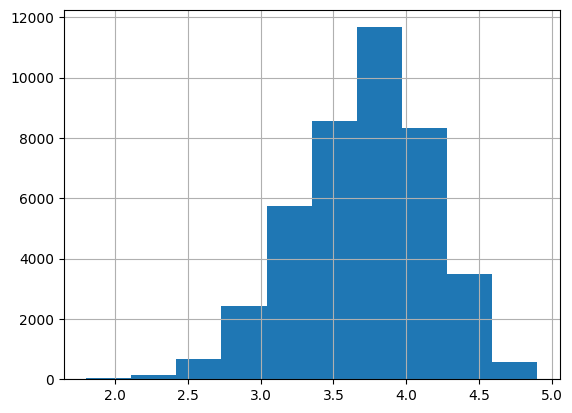

In [13]:
print(df['rate(5)'].describe())
df['rate(5)'].hist()

As per results above, the median is equal to mean somehow, so we will replace nulls with meadian.

count    49440.000000
mean         3.700378
std          0.404394
min          1.800000
25%          3.500000
50%          3.700000
75%          4.000000
max          4.900000
Name: rate(5), dtype: float64
[4.1 3.8 3.7 3.6 4.6 4.  4.2 3.9 3.1 3.  3.2 3.3 2.8 4.4 4.3 2.9 3.5 2.6
 3.4 4.5 2.5 2.7 4.7 2.4 2.2 2.3 4.8 4.9 2.1 2.  1.8]


<Axes: >

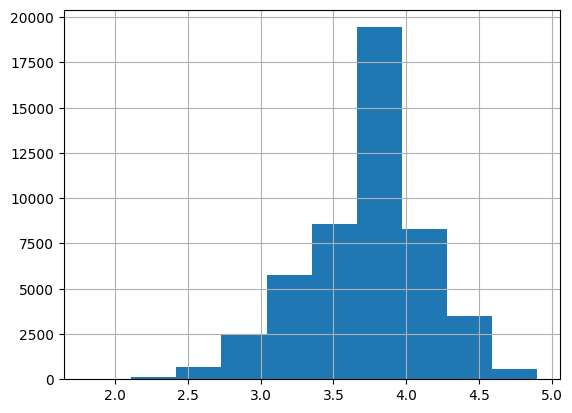

In [14]:
median = df['rate(5)'].median()
df['rate(5)'] = df['rate(5)'].fillna(median,axis=0)

print(df['rate(5)'].describe())
print(df['rate(5)'].unique())

df['rate(5)'].hist()

In [15]:
# Check the votes attribute to check if there's any problem.

print(df['votes'].unique())

[ 775  787  918 ... 4957 2382  843]


In [16]:
# Check the votes attribute to check if there's any problem.

df['cost_for_two'].unique()

array(['800', '300', '600', '700', '550', '500', '450', '650', '400',
       '900', '200', '750', '150', '850', '100', '1,200', '350', '250',
       '950', '1,000', '1,500', '1,300', '199', '1,100', '1,600', '230',
       '130', '80', '50', '190', '1,700', nan, '180', '1,350', '2,200',
       '1,400', '2,000', '1,800', '1,900', '330', '2,500', '2,100',
       '3,000', '2,800', '3,400', '40', '1,250', '3,500', '4,000',
       '2,400', '2,600', '120', '1,450', '469', '70', '3,200', '60',
       '240', '6,000', '1,050', '2,300', '4,100', '5,000', '3,700',
       '1,650', '2,700', '4,500', '140', '360'], dtype=object)

- As we can see, there's wrong entry of numbers they put (**,**) for decimal instead of (**.**) we need to fix them.
- changing the datatype to float
- We need to fill nulls

['800' '300' '600' '700' '550' '500' '450' '650' '400' '900' '200' '750'
 '150' '850' '100' '1.200' '350' '250' '950' '1.000' '1.500' '1.300' '199'
 '1.100' '1.600' '230' '130' '80' '50' '190' '1.700' nan '180' '1.350'
 '2.200' '1.400' '2.000' '1.800' '1.900' '330' '2.500' '2.100' '3.000'
 '2.800' '3.400' '40' '1.250' '3.500' '4.000' '2.400' '2.600' '120'
 '1.450' '469' '70' '3.200' '60' '240' '6.000' '1.050' '2.300' '4.100'
 '5.000' '3.700' '1.650' '2.700' '4.500' '140' '360']

Nulls percentage = 0.6897249190938511% 

cost_for_two
1.00      1590
1.05         4
1.10       493
1.20       984
1.25         8
          ... 
750.00     751
800.00    2162
850.00     153
900.00     690
950.00      60
Name: count, Length: 68, dtype: int64
count    49099.000000
mean       361.297400
std        231.111464
min          1.000000
25%        200.000000
50%        350.000000
75%        500.000000
max        950.000000
Name: cost_for_two, dtype: float64


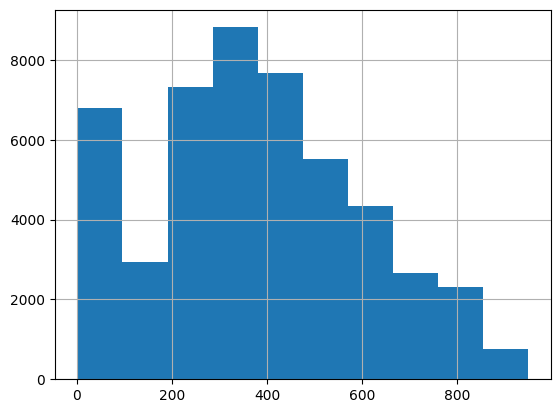

In [17]:
df['cost_for_two'] = df['cost_for_two'].str.replace(',','.')
print(df['cost_for_two'].unique())

df['cost_for_two'] = df['cost_for_two'].astype(float)

print(f"\nNulls percentage = {100*((df['cost_for_two'].isnull().sum()) / len(df))}% \n")
df['cost_for_two'].hist()

print(df['cost_for_two'].value_counts().sort_index())
print(df['cost_for_two'].describe())


- The nulls are very small percentage, and the distribution is right skewed somehow, so we'll use median to replace

In [18]:
median = df['cost_for_two'].median()
df['cost_for_two'] = df['cost_for_two'].fillna(median)
df['cost_for_two'].describe()

count    49440.000000
mean       361.219479
std        230.314950
min          1.000000
25%        200.000000
50%        350.000000
75%        500.000000
max        950.000000
Name: cost_for_two, dtype: float64

In [19]:
# Filling nulls in (Location) with corresponding values in (city)

df['Neighborhood'] = df['Neighborhood'].fillna(df['City'])

In [20]:
# Checking the votes, if it has outliers
df['votes'].describe()

count    49440.000000
mean       296.763451
std        819.779986
min          0.000000
25%          9.000000
50%         47.000000
75%        212.000000
max      16832.000000
Name: votes, dtype: float64

[6 4 5 2 7 3 1 8 0 9]


<Axes: >

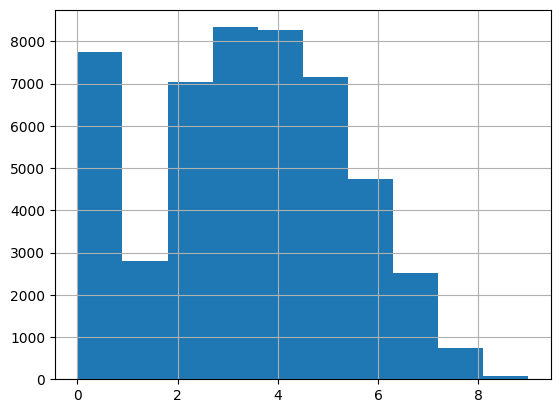

In [21]:
# we will use log normalization to keep the size of data, as if we trim the outliers, it will remove a huge number of rows.

df['log votes'] = (np.log1p(df['votes'])).astype(int)
print(df['log votes'].unique())
df['log votes'].hist()

In [22]:
# Rearrange the columns order

cols = ['name', 'url','phone' ,'online_order', 'book_table', 'cost_for_two','rate(5)', 'votes', 'log votes','Neighborhood','City', 'rest_category','Meal type',
        'dish_liked', 'cuisines','reviews_list']
df = df[cols]

In [23]:
check(df)

,Name,Data type,Nulls Number,Unique,Total value counts
0,name,object,0,8458,49440
1,url,object,0,49440,49440
2,phone,object,0,14403,49440
3,online_order,object,0,2,49440
4,book_table,object,0,2,49440
5,cost_for_two,float64,0,68,49440
6,rate(5),float64,0,31,49440
7,votes,int64,0,2328,49440
8,log votes,int32,0,10,49440
9,Neighborhood,object,0,93,49440


### Now the data is clear and clean, let's go for analysis

In [24]:
# Save the new cleaned data 

df.to_csv('zomato new.csv')

# Analysis process

## First: Univariate analysis 

##### 1- What's the total number of restaurants do we have ?

In [24]:
print(f"Total number of unique restaurants  = {len(df.name.unique())}\n")

Total number of unique restaurants  = 8458



##### 2- what's the percentage of resturants that make online order?

Text(0.5, 1.0, 'Percentage of resturants that make online order')

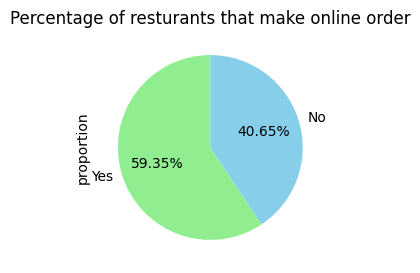

In [25]:
order_counts = df['online_order'].value_counts(normalize=True)
order_counts.plot(kind='pie', figsize=(3, 3), autopct='%1.2f%%', startangle=90, colors=['lightgreen','skyblue'])
plt.title("Percentage of resturants that make online order")

Conclusion : Restaurants that have the option to order online are about (61.84%) and (38.16%) of them haven't.
  

##### 3- what's the percentage of restaurants that can book tables?

Text(0.5, 1.0, 'Percentage of resturants that can book tables')

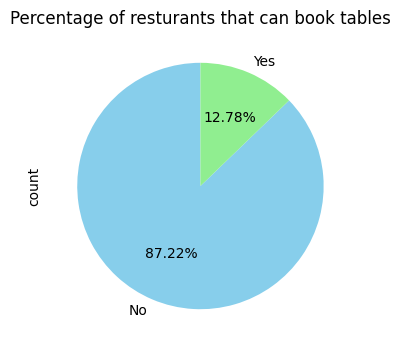

In [26]:
order_counts = df['book_table'].value_counts()

order_counts.plot(kind='pie', figsize=(4, 4), autopct='%1.2f%%', startangle=90, colors=['skyblue','lightgreen'])

plt.title("Percentage of resturants that can book tables")

Conclusion: big percentage of the restaurants haven't the option to book table by (95.62%) and (4.38%) can.

##### 4- what's the top 10 and bottom 10 frequent categories of returants ?

In [27]:
def top_bottom(df, title):
    list_type_counts = df.value_counts().sort_values()
    top = list_type_counts[-10:]
    bottom = list_type_counts[:10]
    
    fig, ax = plt.subplots(1,2, figsize=(25,6))
    
    ax[1].barh(top.index, top.values, color='skyblue')
    ax[0].barh(bottom.index, bottom.values, color='darkred')
    
    ax[1].set_title(f"Top 10 frequent {title}", fontsize=20)
    ax[0].set_title(f"Bottom 10 frequent {title}", fontsize=20)


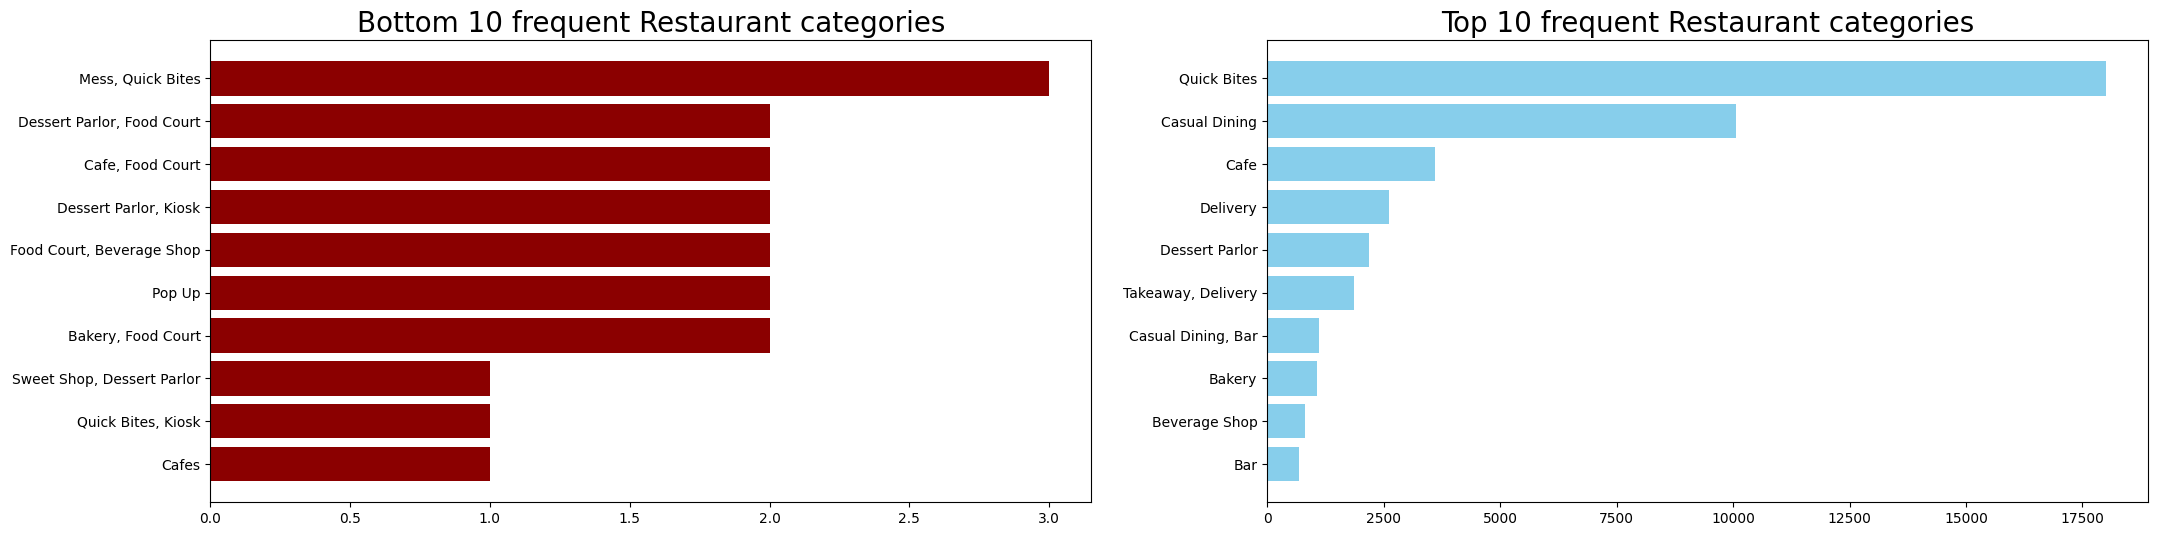

In [28]:
top_bottom(df['rest_category'],'Restaurant categories')

##### 5- what's the statistic summary of cost ?

Summary statistics of Cost for two
count    49440.000000
mean       361.219479
std        230.314950
min          1.000000
25%        200.000000
50%        350.000000
75%        500.000000
max        950.000000
Name: cost_for_two, dtype: float64


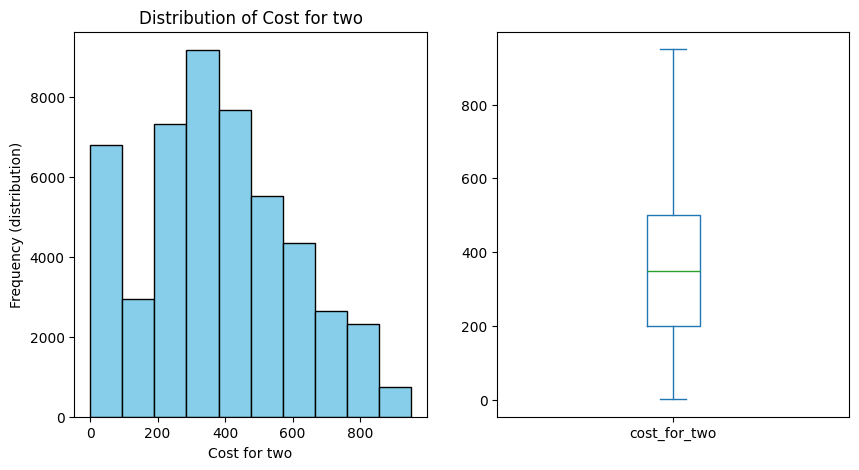

In [29]:
def summary(df, title):
    print(f"Summary statistics of {title}\n{df.describe()}")
    
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    
    ax[0].hist(df, color = 'skyblue', edgecolor='black')
    ax[0].set_title(f'Distribution of {title}')
    ax[0].set_xlabel(title)
    ax[0].set_ylabel('Frequency (distribution)')

    df.plot(kind = 'box')

summary(df['cost_for_two'],'Cost for two')

- As we can see the cost value have a small right skewness.
- The min cost is 5 max cost is 950$

##### 6- what's the statistic summary of rating?

Summary statistics of Rating
count    49440.000000
mean         3.700378
std          0.404394
min          1.800000
25%          3.500000
50%          3.700000
75%          4.000000
max          4.900000
Name: rate(5), dtype: float64


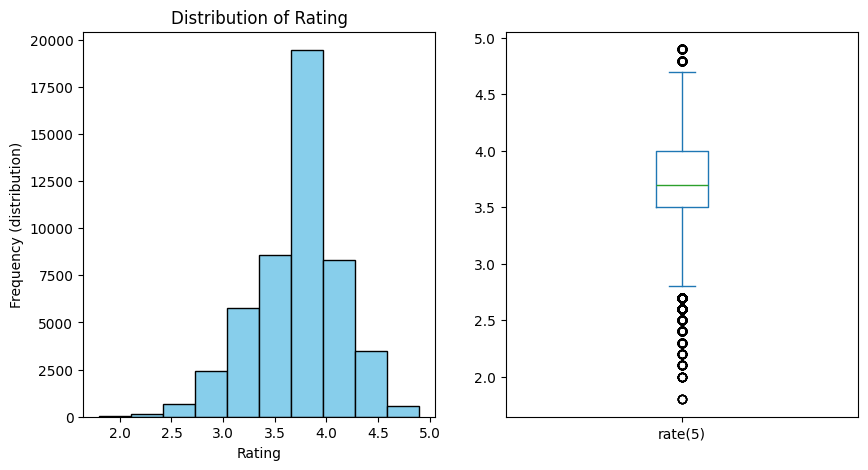

In [30]:
summary(df['rate(5)'], 'Rating')

- The values are left skewed somehow due to ouliers shown in the boxplot, but we need to keep them for the model.
- The min rate is 2, max rate is 4.9, out of 5.

##### 7- what's the statistic summary of logged votes and original votes?

Summary statistics of Normalized Votes
count    49440.000000
mean         3.306756
std          2.131680
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max          9.000000
Name: log votes, dtype: float64


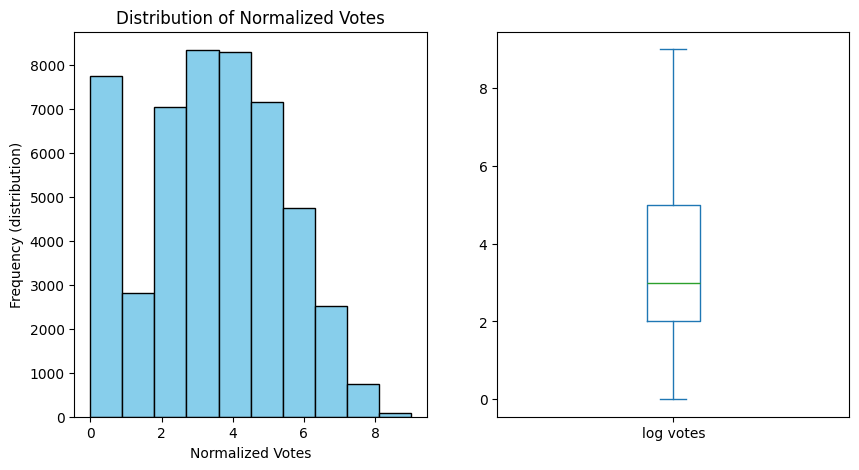

In [31]:
summary(df['log votes'], 'Normalized Votes')

Summary statistics of Original Votes
count    49440.000000
mean       296.763451
std        819.779986
min          0.000000
25%          9.000000
50%         47.000000
75%        212.000000
max      16832.000000
Name: votes, dtype: float64


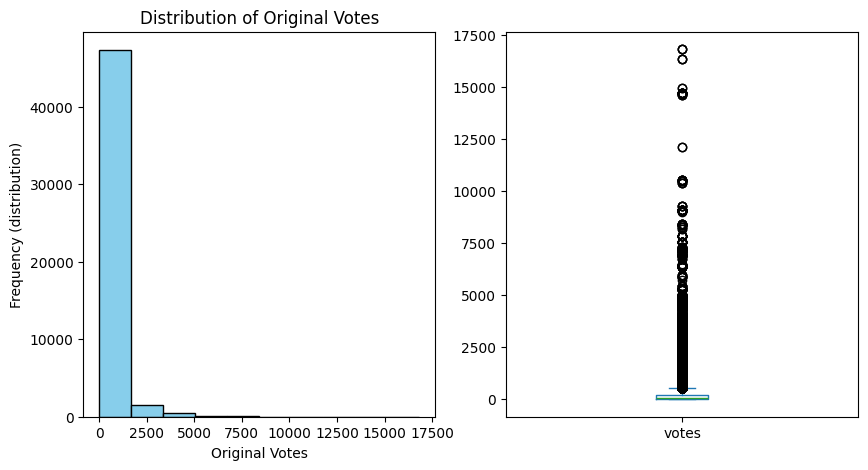

In [32]:
summary(df['votes'], 'Original Votes')

##### 8- what's the top 10 and bottom 10 frequent restaurants

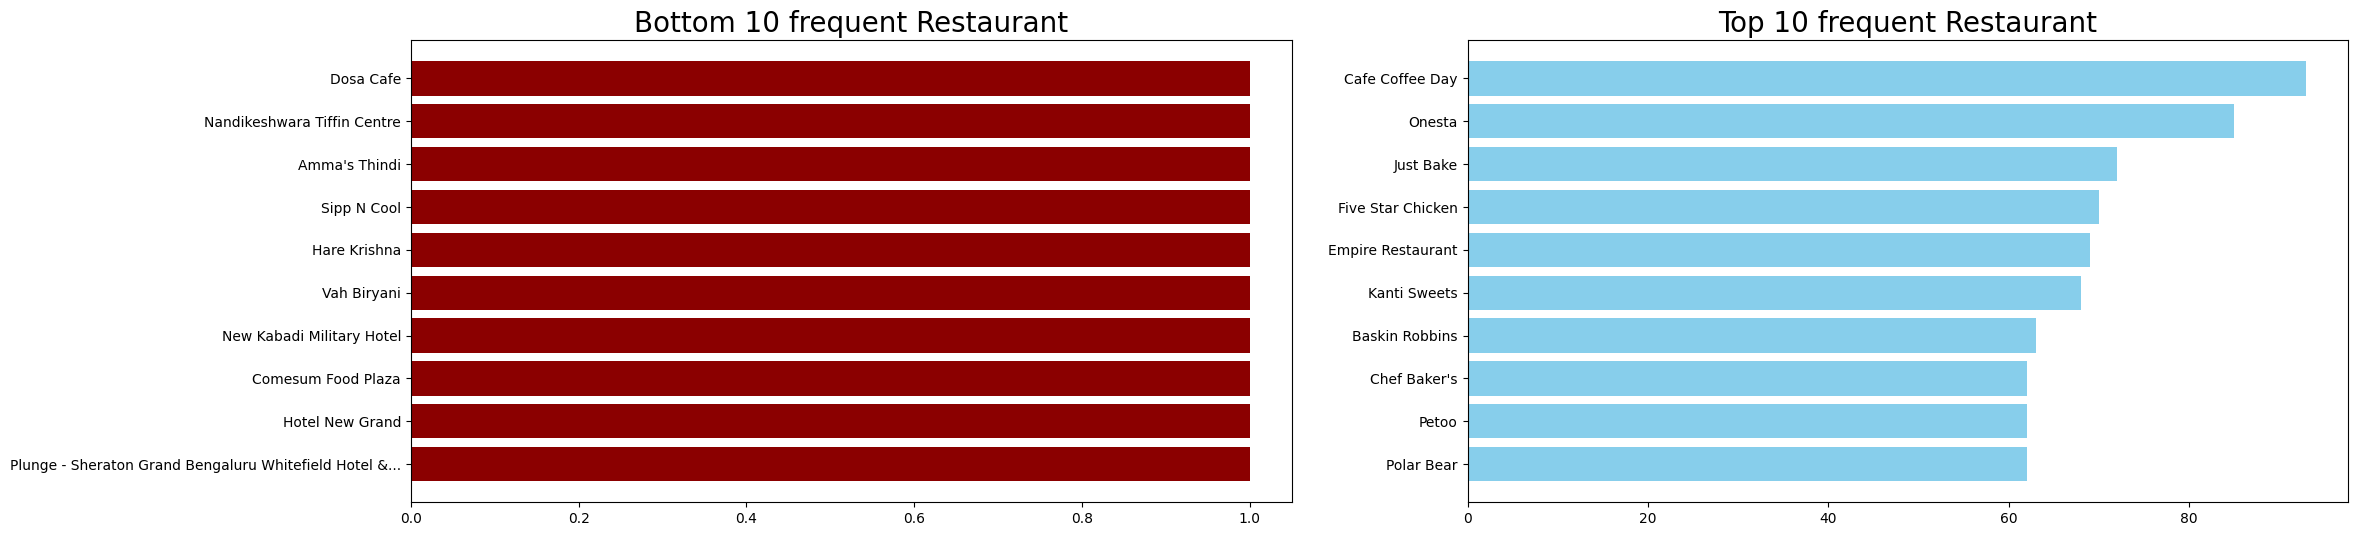

In [33]:
top_bottom(df['name'],'Restaurant')

##### 9- What's the top 10 and bottom 10 frequent neighborhoods?

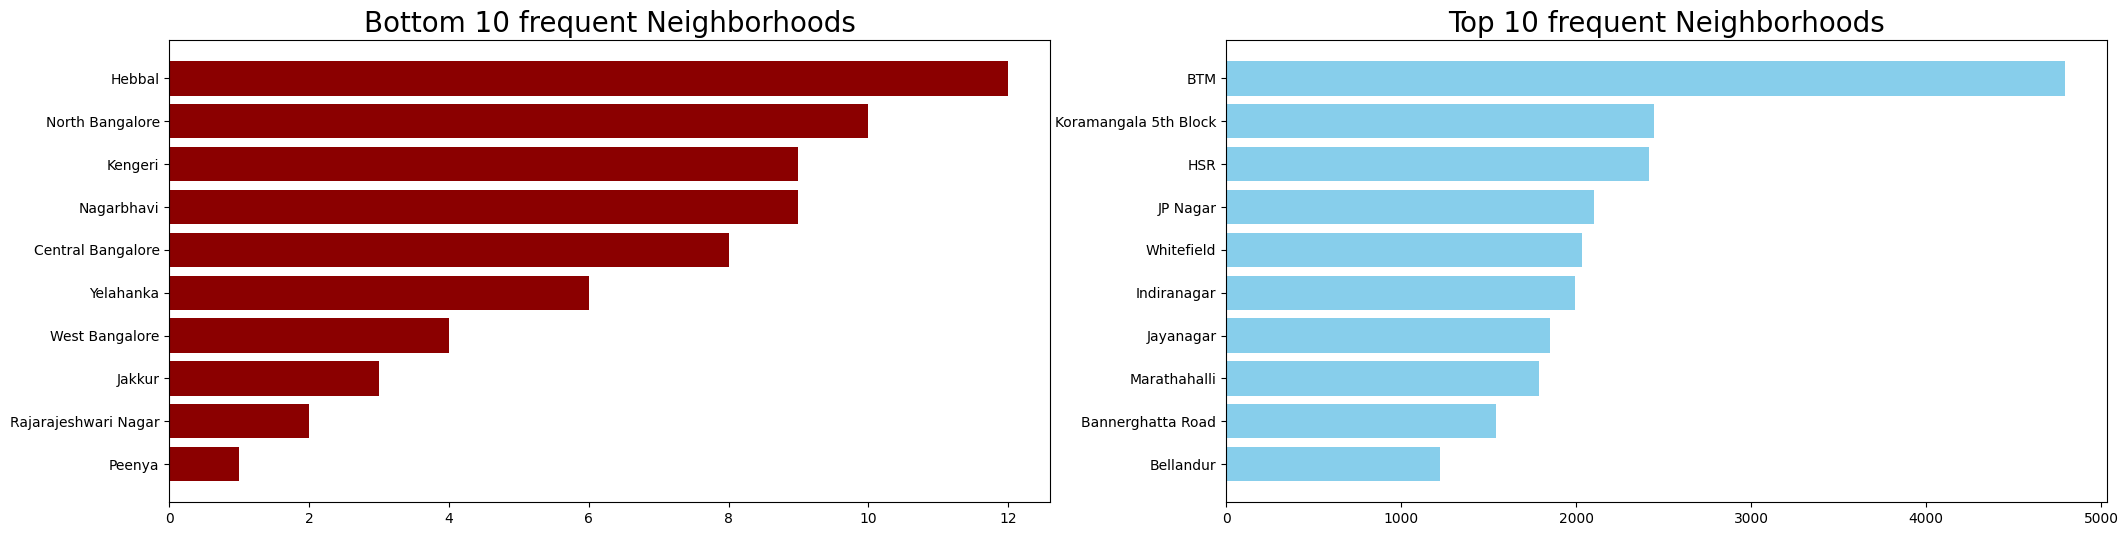

In [34]:
top_bottom(df['Neighborhood'], 'Neighborhoods')

##### 10- What's the distributions of meal types?

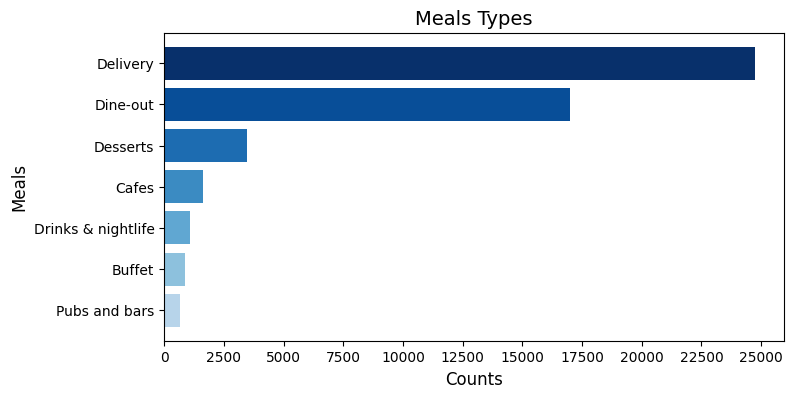

In [35]:
meals = df['Meal type'].value_counts()
index = meals.index
values = meals.values

plt.figure(figsize=(8,4))

colors = cm.Blues(np.linspace(1, .3, len(values)))

plt.barh(index, values, color=colors)
plt.title('Meals Types', fontsize=14)
plt.xlabel('Counts', fontsize=12)
plt.ylabel('Meals', fontsize=12)
plt.xticks(range(0,meals.values.max()+500,2500))
plt.gca().invert_yaxis()
plt.show()

##### 11- What's the top 10 and bottom 10 frequent cities?


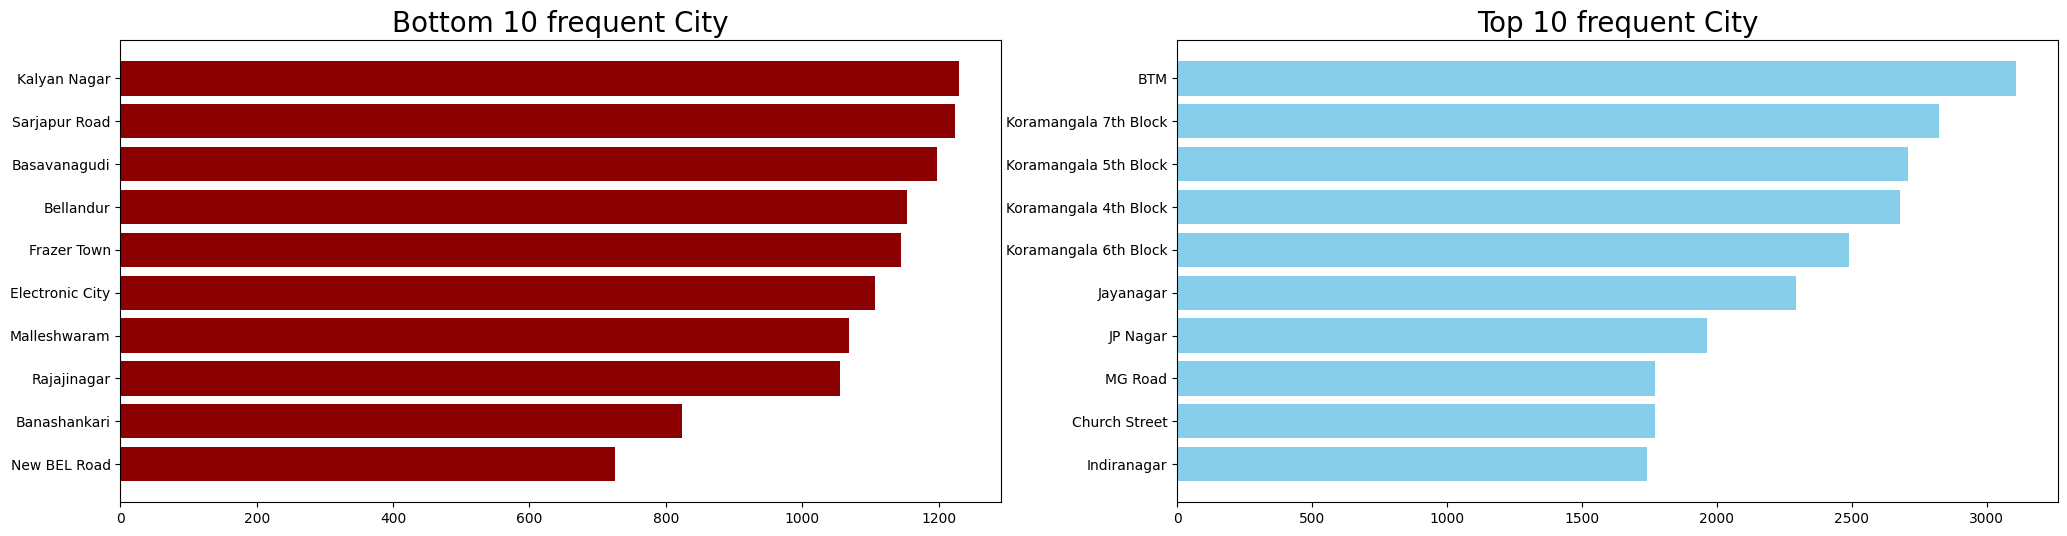

In [36]:
top_bottom(df['City'], 'City')

##### 12- What's the top 10 and bottom 10 frequent categories?

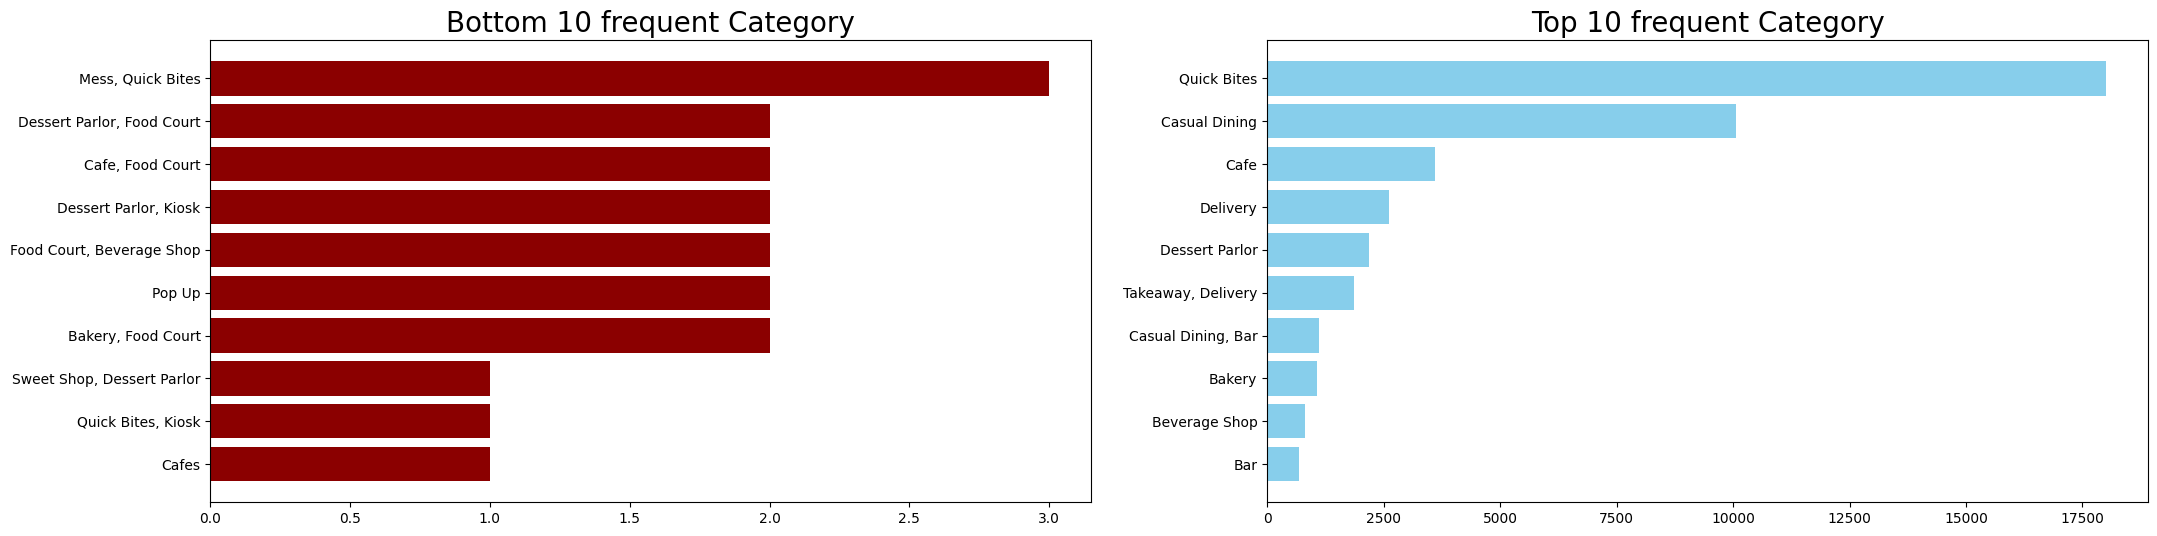

In [37]:
top_bottom(df['rest_category'] , 'Category')

## Second: Bivariate and multivariate analysis:

##### 1- What's the correlation between the features ?

C:\Users\ziad.saad\AppData\Local\Temp\ipykernel_22088\1491232603.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr[col] = le.fit_transform(df_corr[col])
C:\Users\ziad.saad\AppData\Local\Temp\ipykernel_22088\1491232603.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr[col] = le.fit_transform(df_corr[col])
C:\Users\ziad.saad\AppData\Local\Temp\ipykernel_22088\1491232603.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

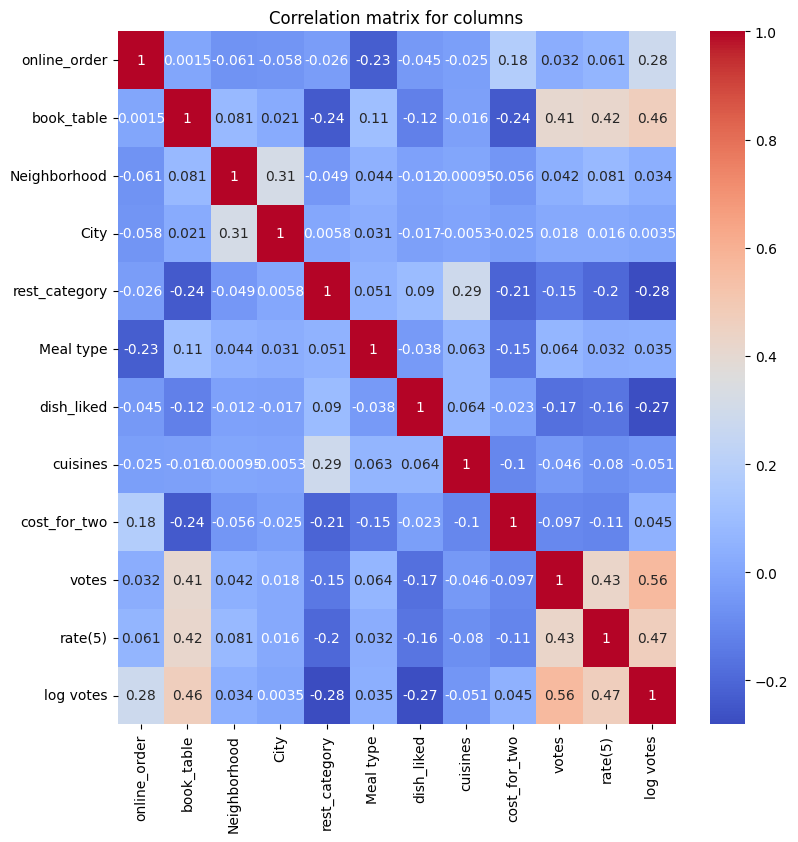

In [38]:
df_corr = df[['online_order', 'book_table','Neighborhood', 'City', 'rest_category', 'Meal type','dish_liked', 'cuisines']]

le = LabelEncoder()
cols = df_corr.columns

for col in cols:
    df_corr[col] = le.fit_transform(df_corr[col])

df_corr[['cost_for_two','votes','rate(5)','log votes']] = df[['cost_for_two','votes','rate(5)','log votes']].copy()


corr_matrix = df_corr.corr()

fig, ax = plt.subplots(figsize=(9,9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Correlation matrix for columns')

plt.show()

Conclusion: As we can see above, There's no correlation between the columns, They are independent somehow.

##### 2- Does the acceptance of online orders and table booking perecence affect the average cost for two people?


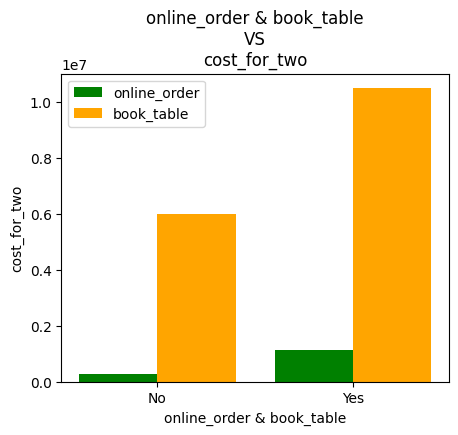

In [39]:
def group(df, col1, col2):
    df_grouped = df.groupby(col1)[col2].sum().unstack()
    
    x = np.arange(len(df_grouped.index))
    fig, ax = plt.subplots(figsize=(5, 4))
    
    ax.bar(x- 0.2 ,df_grouped['Yes'], 0.4, label='Booked Table', color='green')
    ax.bar(x+ 0.2, df_grouped['No'], 0.4, label='Did Not Book Table', color='orange')
    
    ax.set_xticks(x)
    ax.set_xticklabels(df_grouped.index)
    ax.set_xlabel(f'{col1[0]} & {col1[1]}')
    ax.set_ylabel(col2)
    ax.set_title(f"{col1[0]} & {col1[1]}\nVS\n{col2}")
    ax.legend(col1)
    
    plt.show()

group(df, ['online_order','book_table'], 'cost_for_two')

conclusion: If the restaurants has option to order online and booking table, it increases the cost somehow as it's appeared in the yellow andgreen plots in (Yes) category.

##### 3- Does the acceptance of online orders and table booking perecence affect the average user rating ?

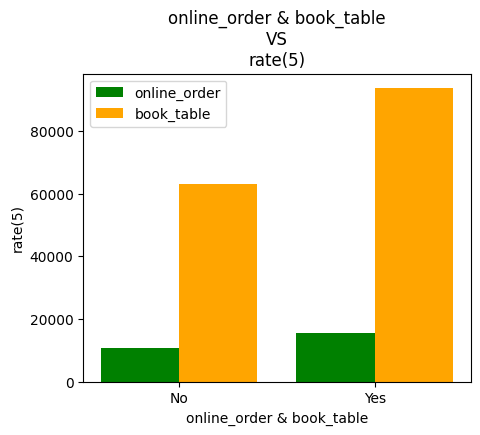

In [40]:
group(df, ['online_order','book_table'],'rate(5)')

conclusion: 
- If the restaurants has option for booking table, it increases the rating with big effect as it's appeared in the yellow plots.
- If the restaurants has option to Order online, it increases the rating with very small effect as it's appeared in the green plots.

##### 4- Does the acceptance of online orders and table booking perecence affect the restaurants votes ?

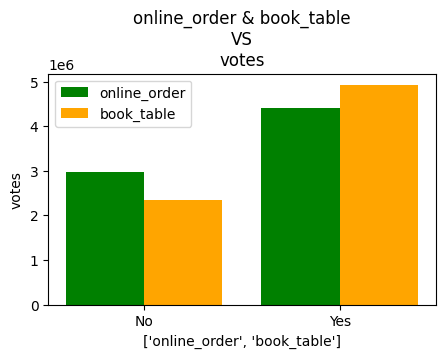

In [41]:
def group(df, col1, col2):
    df_grouped = df.groupby(col1)[col2].sum().unstack()
    
    x = np.arange(len(df_grouped.index))
    fig, ax = plt.subplots(figsize=(5, 3))
    
    ax.bar(x- 0.2 ,df_grouped['Yes'], 0.4, label='Booked Table', color='green')
    ax.bar(x+ 0.2, df_grouped['No'], 0.4, label='Did Not Book Table', color='orange')
    
    ax.set_xticks(x)
    ax.set_xticklabels(df_grouped.index)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.set_title(f"{col1[0]} & {col1[1]}\nVS\n{col2}")
    ax.legend(col1)
    
    plt.show()
group(df, ['online_order','book_table'], 'votes')

conclusion: As we can see that the more number of votes is increased whether if we the option to order online or if there's table booking

##### 5- Which top 10 restaurant categories that have the highest voting, rating, cost?

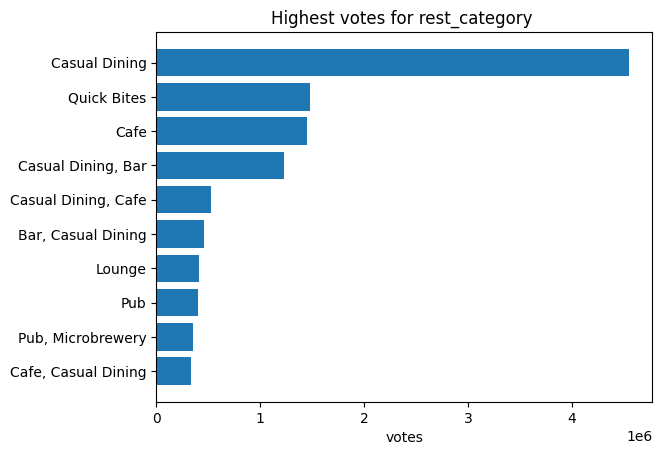

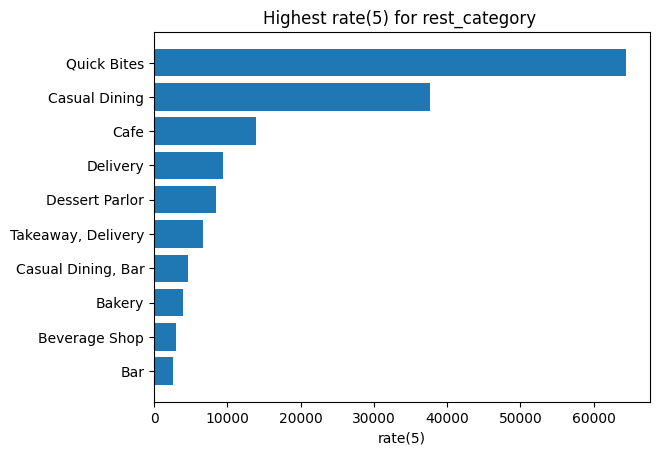

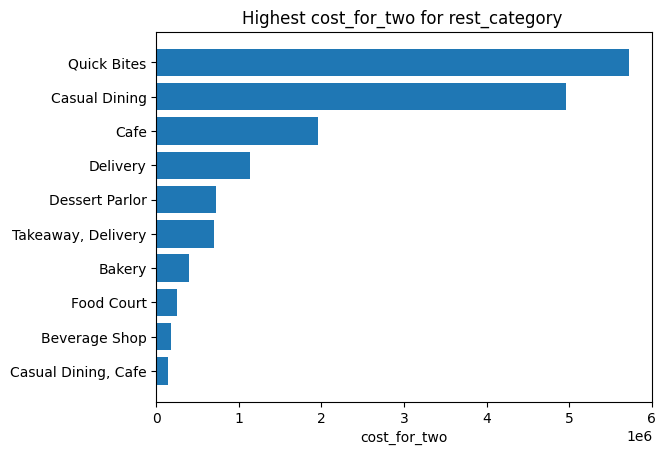

In [42]:
def high_3(df, col1, col2):

    for i,col in enumerate(col2):
        v1 = df.groupby(col1)[col].sum().sort_values()[-10:]
        plt.barh(v1.index, v1.values)
        plt.xlabel(col2[i])
        plt.title(f'Highest {col} for {col1} ')
        plt.show()

high_3(df, 'rest_category', ['votes','rate(5)', 'cost_for_two'])

##### 6- Which bottom 10 restaurant categories that have the lowest voting, rating, cost?

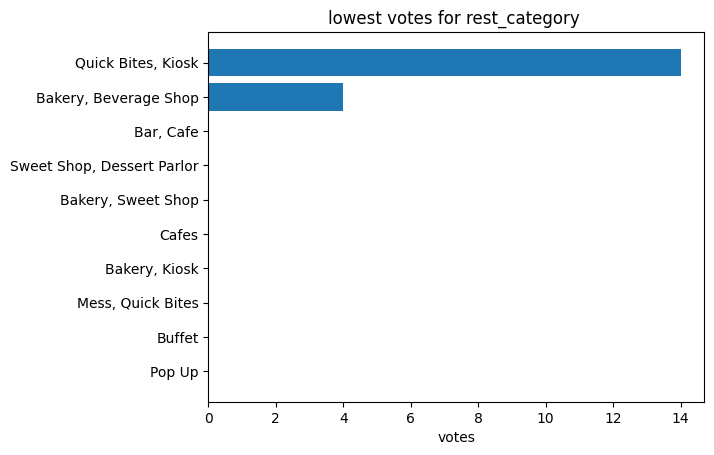

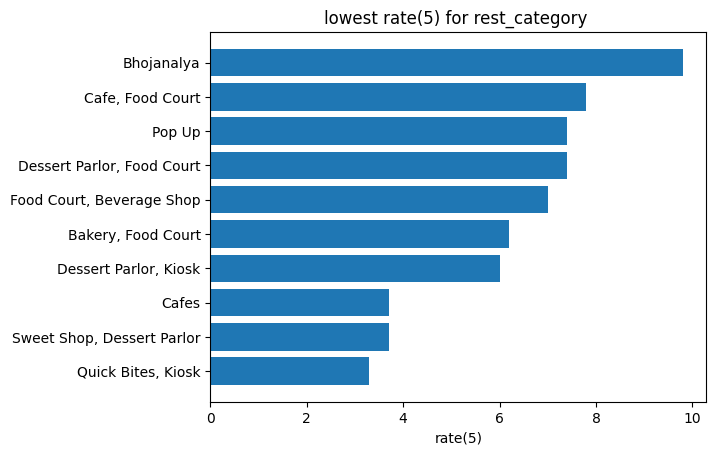

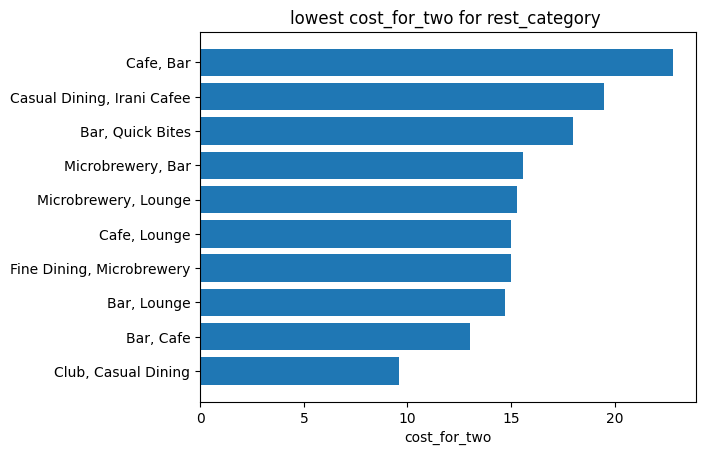

In [43]:
def low_3(df, col1, col2):

    for i,col in enumerate(col2):
        v1 = df.groupby(col1)[col].sum().sort_values()[:10]
        plt.barh(v1.index, v1.values)
        plt.xlabel(col2[i])
        plt.title(f'lowest {col} for {col1} ')
        plt.show()

low_3(df, 'rest_category', ['votes','rate(5)', 'cost_for_two'])

##### 7- Which Meal type has the highest voting, rating, cost?

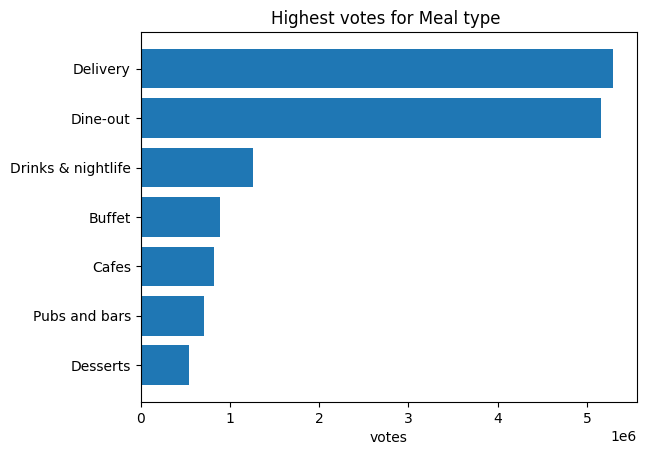

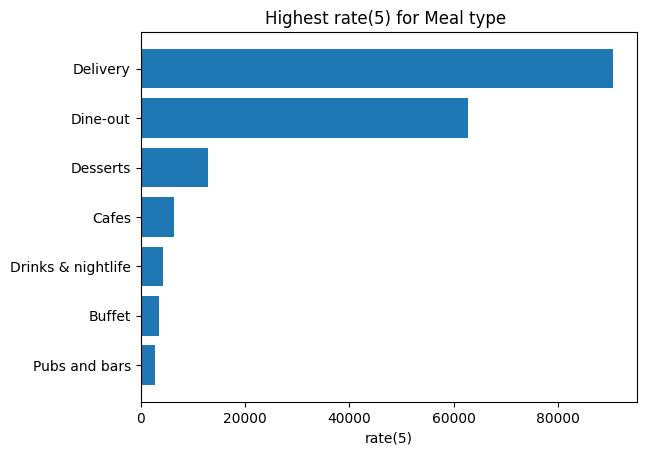

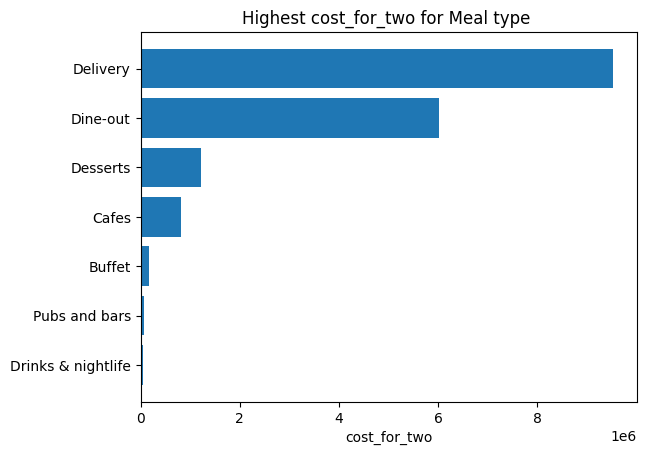

In [44]:
high_3(df,'Meal type' ,['votes','rate(5)', 'cost_for_two'])

##### 8- Which bottom 10 Neighborhoods that their restaurants that have lowest voting, rating, cost ?

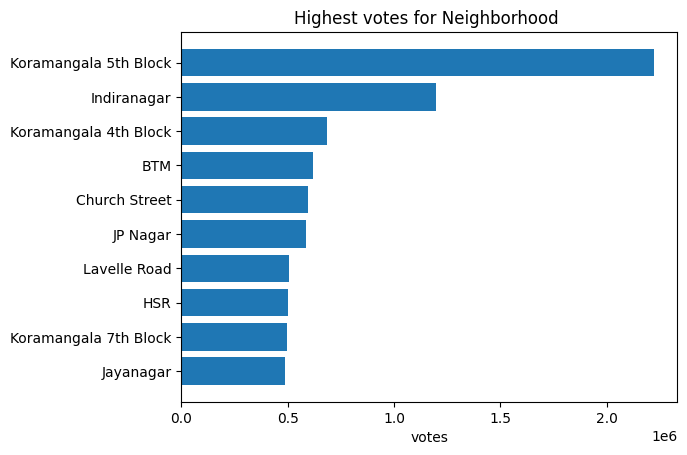

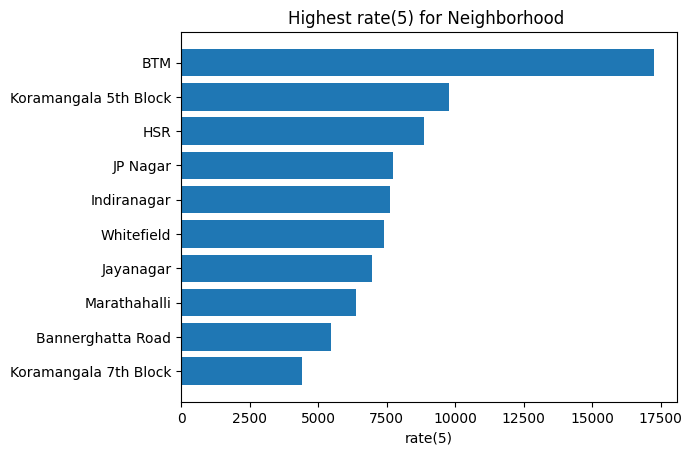

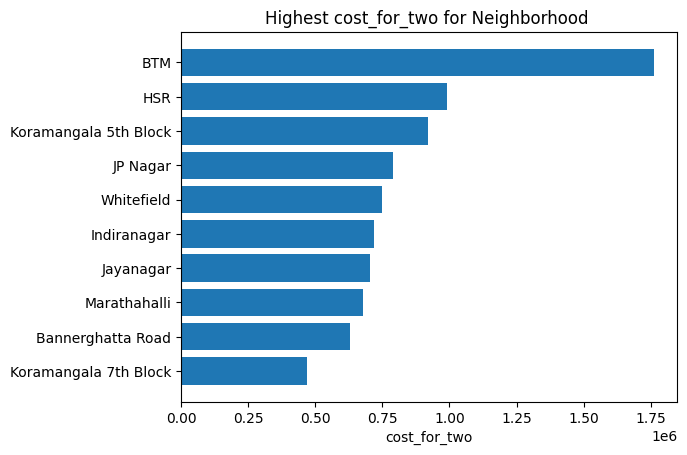

In [45]:
high_3(df, 'Neighborhood', ['votes', 'rate(5)', 'cost_for_two'])

##### 9- Which top 10 Neighborhoods that their restaurants that have highest voting, rating, cost ?

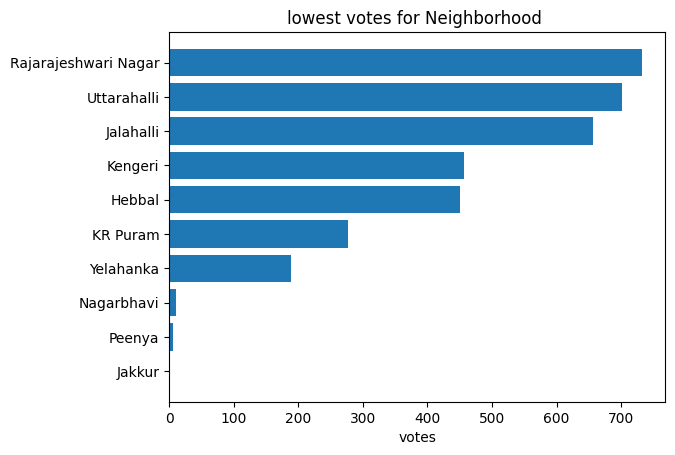

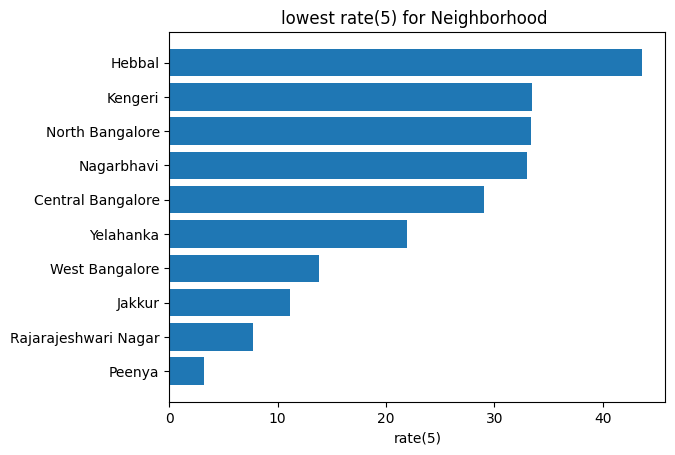

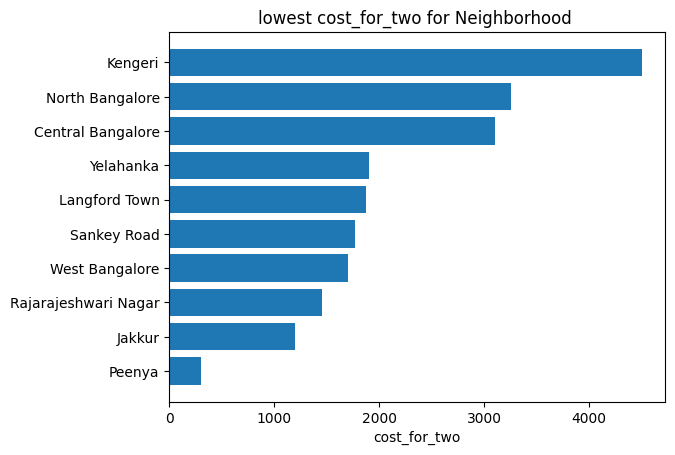

In [46]:
low_3(df, 'Neighborhood', ['votes', 'rate(5)', 'cost_for_two'])

##### 10- Which top 10 citites restaurants that have highest voting, rating, cost ?

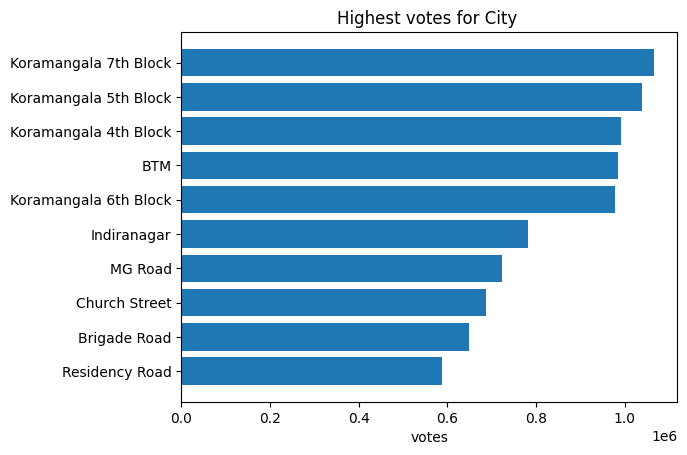

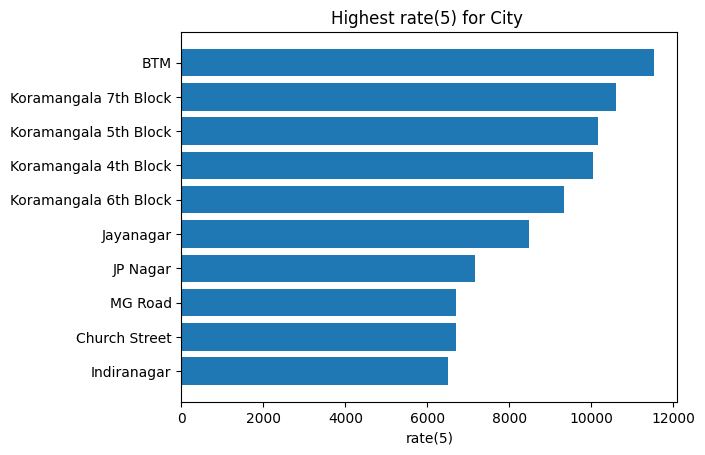

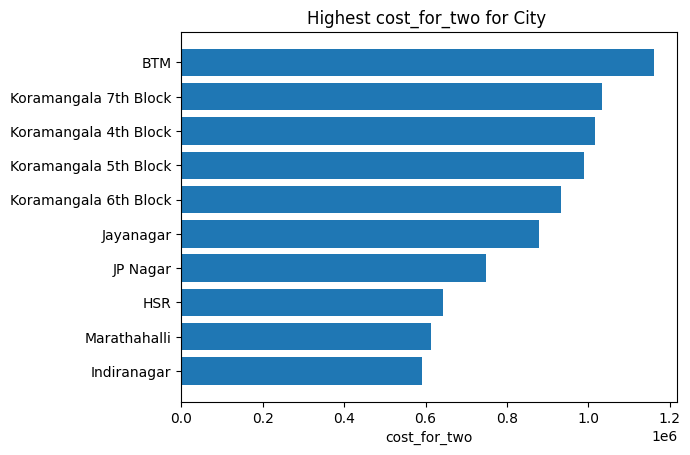

In [47]:
high_3(df, 'City',['votes', 'rate(5)', 'cost_for_two'])

##### 11- Which bottom 10 citites restaurants that lowest voting, rating, cost ?

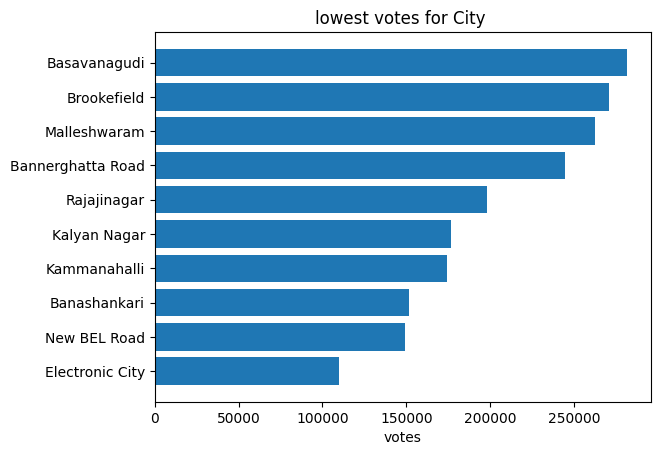

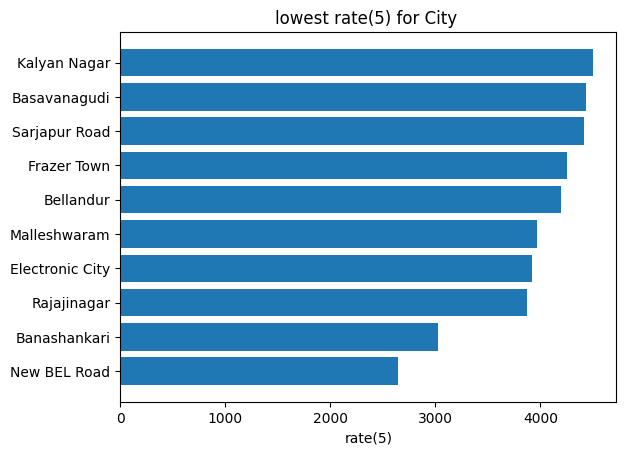

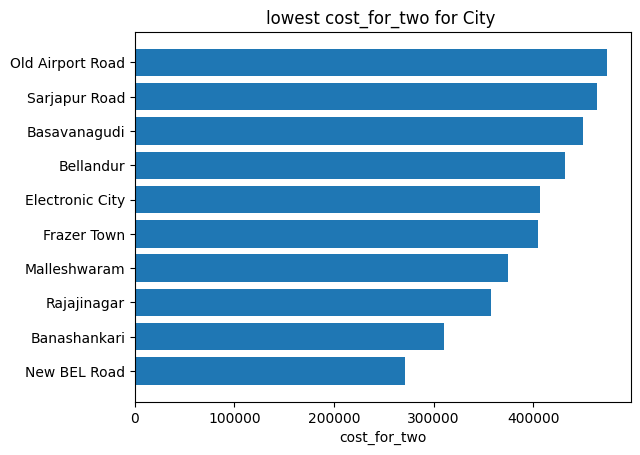

In [48]:
low_3(df, 'City',['votes', 'rate(5)', 'cost_for_two'])

##### 12- Which top 10 cusines that have the highest voting, rating, cost?

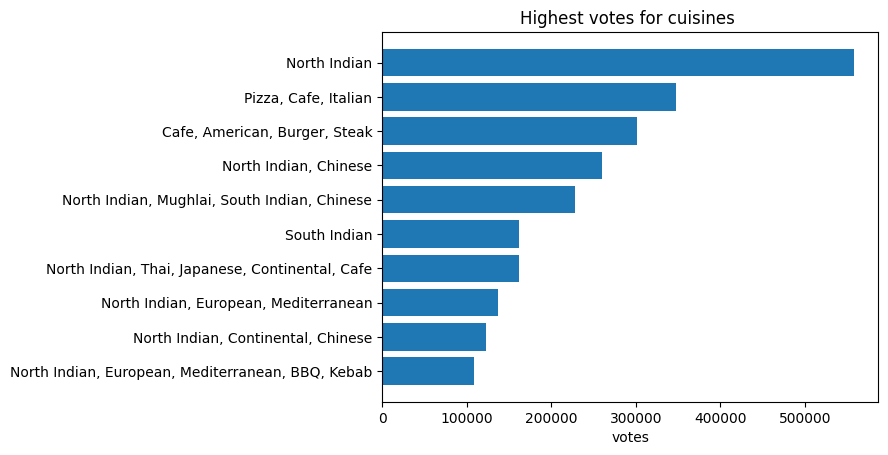

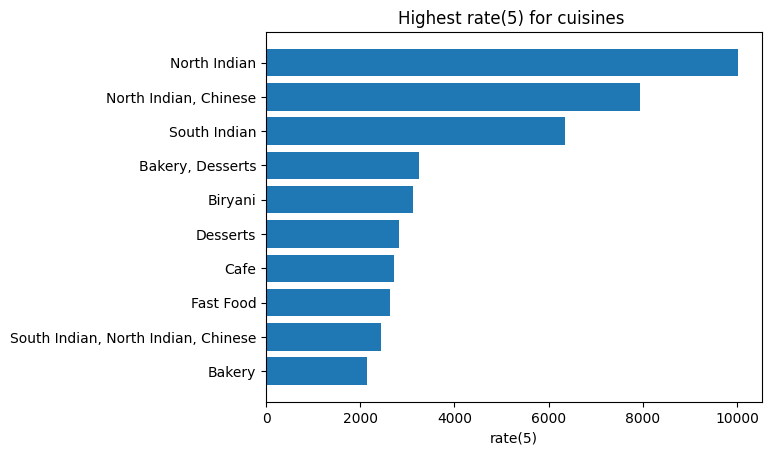

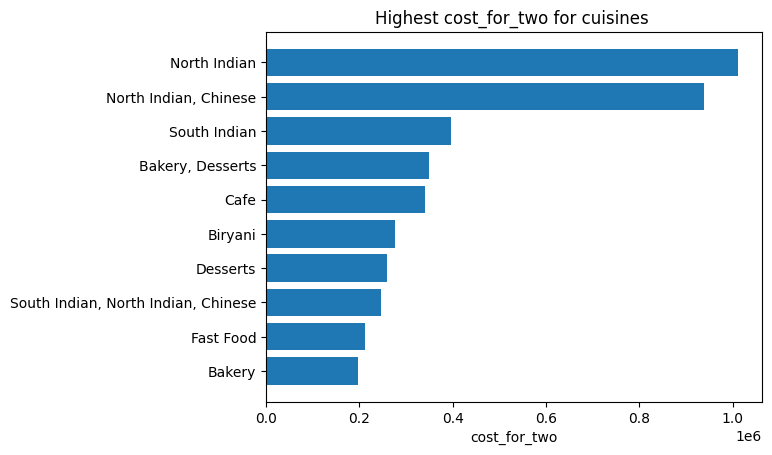

In [49]:
high_3(df, 'cuisines',['votes', 'rate(5)', 'cost_for_two'])

##### 13- hich bottom 10 cusines that have the lowest voting, rating, cost?

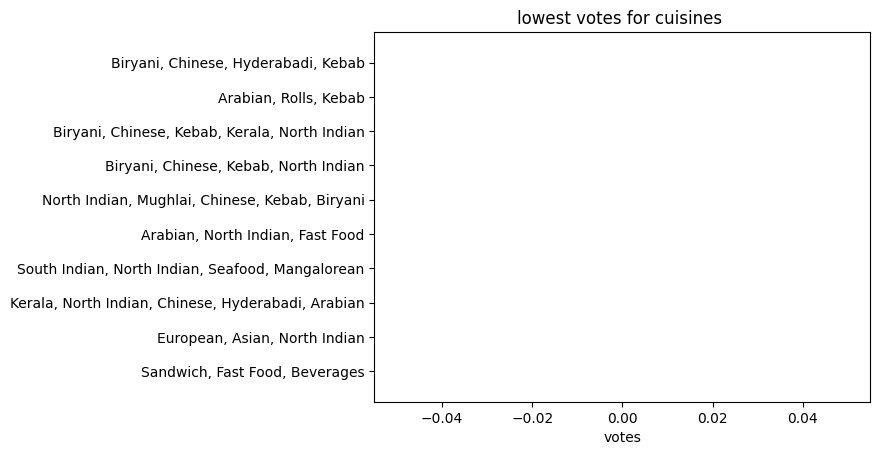

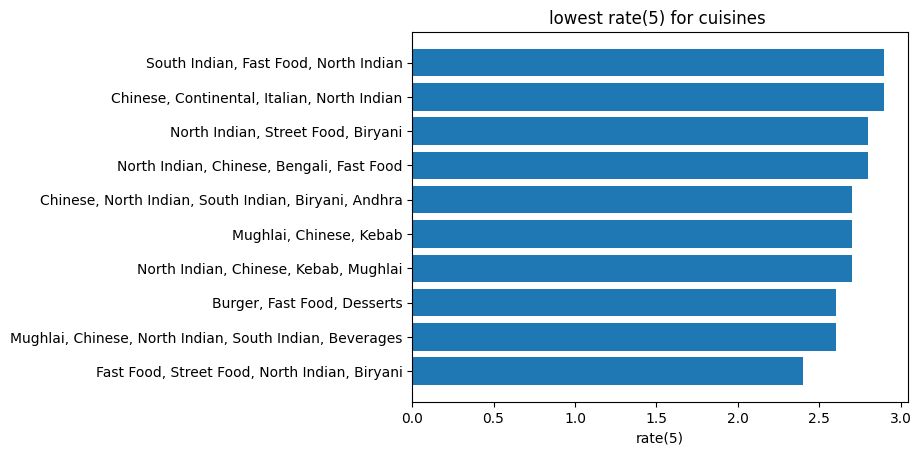

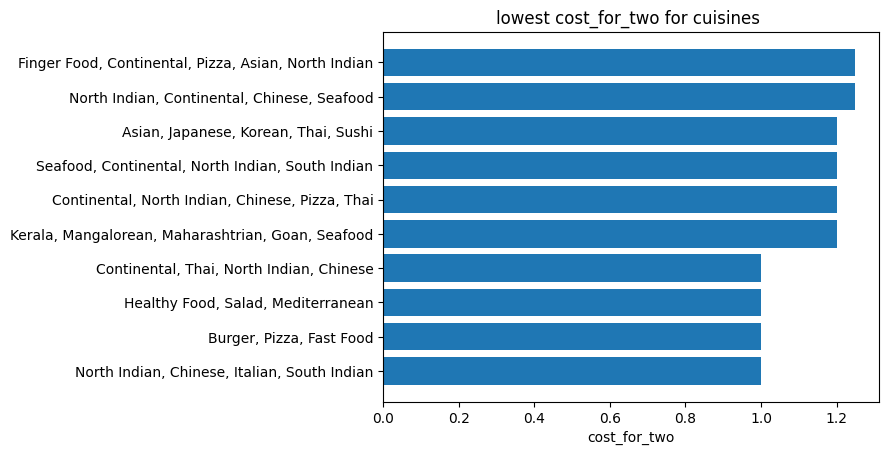

In [50]:
low_3(df, 'cuisines',['votes', 'rate(5)', 'cost_for_two'])

conclusion: The option of online order affects the rate of resturant but with very small influency.

# Applying a LLM to classify the reviews to positive or negative feedbacks.

#### 1- preparing and cleaning the data for the LLM.

In [97]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text)
    text = text.strip()
    text = text.lower()  
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)


In [92]:
# Define the llm prediction function:

def ask_llm(review):
    import logging

    # Suppress unwanted logs from external libraries
    for noisy_logger in ["httpx", "fireworks", "urllib3"]:
        logging.getLogger(noisy_logger).setLevel(logging.WARNING)

    review = clean_text(review)

    # logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    # logger = logging.getLogger(__name__)

    def count_tokens(text, model="accounts/fireworks/models/llama4-maverick-instruct-basic"):
        try:    
            encoding = tiktoken.get_encoding("cl100k_base")
            return len(encoding.encode(text))
        except:
            encoding = tiktoken.get_encoding("cl100k_base")
            return len(encoding.encode(text))

    if not isinstance(review, str) or not review.strip():
        return "Empty input!"
    
    else:
        schema = {
            "type": "object",
            "properties": {
                "output": {
                    "type": "string",
                    "description": "The single review feedback or 'Empty input!'"
                }
            },
            "required": ["output"],
            "additionalProperties": False
        }

        model = ChatFireworks(
            model="accounts/fireworks/models/llama4-scout-instruct-basic",
            temperature=0.1,
            max_tokens=131072, 
            fireworks_api_key="fw_3ZTtMu8yiAV962ddVBRTHBAD",
            top_p=0.3, 
            top_k=3,
        )

        prompt = f"""
        You are a sentiment analysis system. Your task is to return the food review feedback based on a customer's review.
        Your response will be ONLY (Positve) or (Negative)

        Inputs:
        - Review: "{review}"
        
        Instructions:
        - Choose the single best matching feedback for the review.
        - Output format must be strictly: {{"output": "<exact feeback or Empty input!>" }}
        - No extra text, explanation, or formatting

        Examples:
        - Review: "very bad try" → {{ "output": "Negative" }}
        - Review: "what a wonderful place" → {{ "output": "Potive" }}

        predict feedback for this review: "{review}"
        """

        json_model = model.bind(response_format={"type": "json_object", "schema": schema})
        chat_history = [SystemMessage(content=prompt), HumanMessage(content=review)]
        
        system_tokens = count_tokens(prompt)
        human_tokens = count_tokens(review)
        total_input_tokens = system_tokens + human_tokens
        
        # logger.info(f"INPUT TOKENS: {total_input_tokens} (System: {system_tokens}, Human: {human_tokens})")
        # logger.info(f"System prompt: {prompt}")
        # logger.info(f"Human message: {review}")

        try:
            response = json_model.invoke(chat_history)
            content = response.content.strip()
            
            output_tokens = count_tokens(content)
            # logger.info(f"OUTPUT TOKENS: {output_tokens}")
            
            parsed = json.loads(content)
            feedback = parsed.get("output", "Empty input!")
            
            # logger.info(f"TOTAL TOKENS: {total_input_tokens + output_tokens} (Input: {total_input_tokens}, Output: {output_tokens})")
            # logger.info(f"Feedback: {feedback}")
            
            return feedback

        except Exception as e:
            # logger.error(f"ERROR: {str(e)}")
            return "Empty input!"


In [95]:
review = str(input("Enter your review: "))

result = ask_llm(review)
print("Feedback is: ", result)

Feedback is:  Empty input!


# Customizing a streamlit application for the LLM prediction

In [96]:
import streamlit as st

st.set_page_config(page_title="Review Sentiment Predictor", page_icon="🧠")

st.title("🧠 Food Review Sentiment Classifier")
st.markdown("Enter your feedback below and see if it's **Positive** or **Negative**.")

user_review = st.text_area("enter your review, please", placeholder="Type your review here...", height=150)

if st.button("Predict Sentiment"):
    if not user_review.strip():
        st.warning("Please enter a review before predicting.")
    else:
        with st.spinner("Analyzing review..."):
            feedback = ask_llm(user_review)
            if feedback == "Positive":
                st.success("✅ Sentiment: Positive")
            elif feedback == "Negative":
                st.error("❌ Sentiment: Negative")
            else:
                st.info("ℹ️ Result: Empty input or unclear")


2025-05-19 16:02:49.987 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-19 16:02:50.032 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-19 16:02:51.049 
  command:

    streamlit run c:\Users\ziad.saad\Desktop\cities\final\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-05-19 16:02:51.053 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-19 16:02:51.055 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-19 16:02:51.057 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-19 16:02:51.058 Thread 'MainThread': missing ScriptRunContext! This warning can be ig